All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 121:
> This question involves the use of simple linear regression on the `Auto` data set.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.regression, statsmodels.tools, statsmodels.graphics
import statsmodels.graphics.gofplots, statsmodels.graphics.regressionplots
import statsmodels.stats.outliers_influence
from statsmodels.graphics.regressionplots import abline_plot


sns.set()
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
auto = pd.read_csv('https://www.statlearning.com/s/Auto.csv', index_col=0)
auto = auto[auto != '?'].dropna().reset_index()
auto.horsepower = auto.horsepower.astype(np.int16)
auto.origin = auto.origin.astype('category')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


# (a)

<a name="model_summary"></a>
From the textbook, p. 121:
> Use the `lm()` function to perform a simple linear regression with
`mpg` as the response and `horsepower` as the predictor. Use the
`summary()` function to print the results. Comment on the output.

In [3]:
x = auto.drop(['mpg', 'name'], axis='columns')
x = statsmodels.tools.tools.add_constant(x)
y = auto.mpg

lm_horsepower = statsmodels.regression.linear_model.OLS(y, x[['const', 'horsepower']])
lm_horsepower_fit = lm_horsepower.fit(use_t=True)
print(lm_horsepower_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           7.03e-81
Time:                        20:12:39   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

From the textbook, p. 122:
> i. Is there a relationship between the predictor and the response?

The p-value for the t-test on `horsepower` is the magnificent "0.000". Yes, there is a relationship.

> ii. How strong is the relationship between the predictor and
the response?

$R^2 = 0.606.$ `horsepower` explains 60.7% of variation in `mpg`.  

> iii. Is the relationship between the predictor and the response
positive or negative?

Negative. For every unit of `horsepower` there is a 0.1578 drop in `mpg`.

> iv. What is the predicted `mpg` associated with a horsepower of
98? What are the associated 95% confidence and prediction
intervals?

In [4]:
intervals = (lm_horsepower_fit.get_prediction([1, 98])
                              .summary_frame(0.95)
                              .T[0]
)
intervals.index=['Prediction'
                 , 'Standard error'
                 , 'Confidence interval, lower bound'
                 , 'Confidence interval, upper bound'
                 , 'Prediction interval, lower bound'
                 , 'Prediction interval, upper bound'
                ]
intervals

Prediction                          24.467077
Standard error                       0.251262
Confidence interval, lower bound    23.973079
Confidence interval, upper bound    24.961075
Prediction interval, lower bound    14.809396
Prediction interval, upper bound    34.124758
Name: 0, dtype: float64

# (b)

From the textbook, p. 122:
> Plot the response and the predictor. Use the `abline()` function
to display the least squares regression line.

In [5]:
intercept, slope = lm_horsepower_fit.params

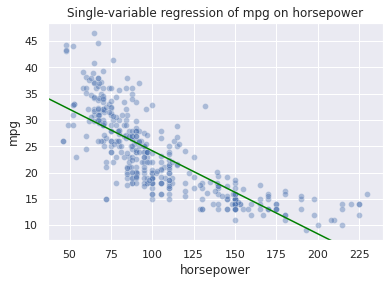

In [6]:
ax = sns.scatterplot(data=auto, x='horsepower', y='mpg', alpha=0.4)
abline_plot(*lm_horsepower_fit.params, ax=ax, color='green')
a = plt.title('Single-variable regression of mpg on horsepower')

# (c)

From the textbook, p. 122:
> Use the `plot()` function to produce diagnostic plots of the least
squares regression fit. Comment on any problems you see with
the fit.

In R, when you execute `plot(<fitted_linear_model>)`, it returns you a plot like this (an example image from [this](https://stats.stackexchange.com/questions/280522/labelled-points-in-plot-of-lm-fit) thread on StackOverflow):
![picture](https://i.stack.imgur.com/Tg0PT.png)

There is no one-to-one match for this in `statsmodels`. I have to replicate it manually.


#### Note
This turned out to be quite an ordeal. `statsmodels` has its own Q-Q plot and leverage plot; the former is good, but the latter is ugly as sin. And there is nothing for the other two plots.

These are the best options I managed to find:
1. **Residual plot:** there is an off-the-shelf one, from [Seaborn](https://seaborn.pydata.org/generated/seaborn.residplot.html).
1. **Q-Q plot:** `statsmodels.graphics.gofplots.qqplot` from [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html).
1. **Scale-location plot:** I used [Seaborn's regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) to build a scatter plot with a local regression line.
1. **Leverage plot:** I used [Seaborn's scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) to build a scatter plot with a local regression line. (I found no benefit in plotting the local regression line). To plot contour lines of Cook's distance, I had to, first, find the [relationship between the Cook's distance, leverage, and standardized residuals](https://en.wikipedia.org/wiki/Cook's_distance#Relationship_to_other_influence_measures_(and_interpretation)), second, use contour plot from [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html). Cook's distance: $$ D_i = \left[ \frac{1}{p} \right] t_i^2 \frac{h_{ii}}{1 - h_{ii}} $$

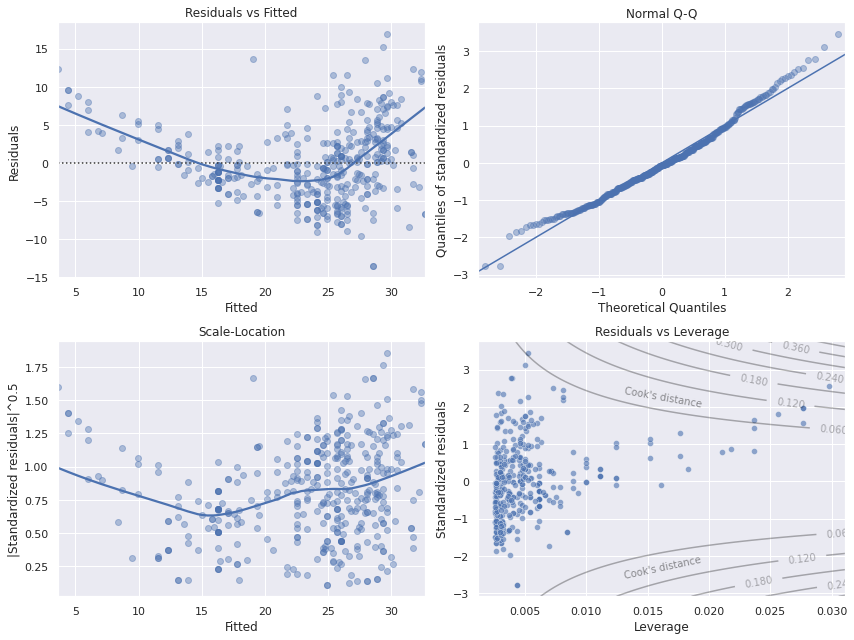

In [7]:
def lm_plot(lm_fit):
  """
  Replicates R's diagnostic plots for a linear model.

  Arguments:
  lm_fit: a fitted OLS model from statsmodels.

  Returns:
  fig, axs: matplotlib subplots on a 2 by 2 grid.
  The plots are:
    - residual plot;
    - Q-Q plot for model's standardized residuals;
    - scale-location plot;
    - leverage plot (also called influence plot).
  """

  fitted = lm_fit.fittedvalues
  influence = lm_fit.get_influence()
  leverage = influence.hat_matrix_diag
  residuals = lm_fit.resid
  standardized_residuals =  influence.resid_studentized_internal

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

  # 1. Upper-left: Residual plot
  sns.residplot(x=fitted
                , y=residuals
                , lowess=True
                , scatter_kws={'alpha' : 0.4}
                , ax=axs[0, 0]
              )
  axs[0, 0].set_title('Residuals vs Fitted')
  axs[0, 0].set_xlabel('Fitted')
  axs[0, 0].set_ylabel('Residuals')

  # 2. Upper-right: Q-Q plot
  statsmodels.graphics.gofplots.qqplot(standardized_residuals, ax=axs[0, 1], alpha=0.4)
  abline_plot(0, 1, ax=axs[0, 1])
  axs[0, 1].set_title('Normal Q-Q')
  axs[0, 1].set_ylabel('Quantiles of standardized residuals')

  # 3. Bottom-left: Scale-location plot
  sns.regplot(x=fitted
              , y=np.abs(standardized_residuals)**0.5
              , lowess=True
              , scatter_kws={'alpha' : 0.4}
              , ax=axs[1, 0]
            )
  axs[1, 0].set_xlabel('Fitted')
  axs[1, 0].set_ylabel('|Standardized residuals|^0.5')
  axs[1, 0].set_title('Scale-Location')

  # 4. Bottom-right: Leverage plot
  axs[1, 1].set_title('Residuals vs Leverage')
  axs[1, 1].set_xlabel('Leverage')
  axs[1, 1].set_ylabel('Standardized residuals')
  sns.scatterplot(x=leverage
              , y=standardized_residuals
              , alpha=0.6
              , ax=axs[1, 1]
            )
  
  l_min, l_max = axs[1, 1].get_xlim()
  leverage_range = np.linspace(l_min, l_max, num=1000)
  sr_min, sr_max = axs[1, 1].get_ylim()
  st_residuals_range = np.linspace(sr_min, sr_max, num=1000)

  leverage, st_residuals = np.meshgrid(leverage_range, st_residuals_range)
  cooks_distance = st_residuals**2 * leverage / (1 - leverage)

  cs = axs[1, 1].contour(leverage
                        , st_residuals
                        , cooks_distance
                        , alpha=0.3
                        , colors='black'
                        )
  axs[1, 1].clabel(cs, inline=True, fontsize=10)
  return fig, axs

fig, axs = lm_plot(lm_horsepower_fit)
axs[1, 1].annotate("Cook's distance", [0.013, -2.6], alpha=0.5, rotation=12.0)
axs[1, 1].annotate("Cook's distance", [0.013, 2.0], alpha=0.5, rotation=-10)

plt.tight_layout()
plt.show()

With the help of [this article](https://data.library.virginia.edu/diagnostic-plots/) let's go plot-by-plot.
1. The U-shaped pattern seen on the **residual plot** suggests that there is non-linearity unexplained by the model.
1. For my uneducated eye, the **Q-Q plot** looks okay. However, I [saw](https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html#Normality-of-the-residuals) Jarque-Bera statistical test being used to test residuals' normality more precisely. Interestingly, it is one of the statistics that [were provided](#model_summary) by `lm_horsepower_fit.summary()`. According to the summary, the probability of the distribution of the residuals being normal is 0.0175%.
1. The scale-location plot is needed to assess *heteroscedasticity* (unevenness of variance) of the fitted model; it is problematic when large. Again, I have little idea just by looking at the plot. Documentation for `statsmodels` [offers](https://www.statsmodels.org/stable/diagnostic.html#heteroscedasticity-tests) three options to test. Let's try all three (naively) and see what happens. 

In [8]:
# I am printing out only the p-value.
sms.diagnostic.het_breuschpagan(lm_horsepower_fit.resid
                                , x[['const', 'horsepower']]
                               )[1]

0.003090136011371003

In [9]:
# I am printing out only the p-value.
sms.diagnostic.het_white(lm_horsepower_fit.resid
                         , x[['const', 'horsepower']]
                        )[1]

2.467156153464497e-10

In [10]:
# I am printing out only the p-value.
sms.diagnostic.het_white(y, x[['const', 'horsepower']])[1]

2.24333746612765e-53

In [11]:
2 / 392

0.00510204081632653

All p-values are low. If one to trust this approach, the sample *is* heteroscedastic &mdash; the error varies depending on the value of `horsepower`.
  4. **Leverage** plot serves to find influential points in data &mdash; the ones that can change the fit dramatically.

  There are two points with studentized residuals greater than 3 &mdash; they are considered outliers. However, their influence of the model's fit may be low, if they have low leverage.

  Cook's distance is a measure of leverage's effect on the model's fit. Original plots from R seem to suggest two threshold values of Cook's distance, 0.5 and 1. If you look at my plot, no points have Cook's distance greater than 0.24. I assume, this means that there are no points of high influence in `horsepower`.